# Lab 01_2: Half-Wavelength CPW Resonator

### developed by Seong Hyeon Park (pajoheji0909@snu.ac.kr)

### Please find the attached homework at the end of this tutorial code

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit_metal import designs, MetalGUI, Dict

design = designs.DesignPlanar()
design.overwrite_enabled = True

## set chip layout size

In [3]:
# set the overall layout size (X)
design.chips.main.size.size_x = '8mm'
# set the overall layout size (Y)
design.chips.main.size.size_y = '4mm'
# set the substrate thickness (Z)
design.chips.main.size.size_z = '-400um'

## start GUI of Qiskit-Metal and ANSYS HFSS

In [4]:
# start GUI
gui = MetalGUI(design)

In [5]:
hfss = design.renderers.hfss
# start ANSYS HFSS
hfss.start()

INFO 01:47PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:47PM [load_ansys_project]: 	Opened Ansys App
INFO 01:47PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 01:47PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/USER/Documents/Ansoft/
	Project:   Project3
INFO 01:47PM [connect_design]: 	Opened active design
	Design:    lab01_quarterCPW_hfss [Solution type: Eigenmode]
INFO 01:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:47PM [connect]: 	Connected to project "Project3" and design "lab01_quarterCPW_hfss" 😀 



True

In [6]:
import pyEPR as epr
import qiskit_metal as metal

## calculate first-cut CPW parameters

In [7]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength

# NOTE use SI units
# target resonant frequency
target_freq = 8e9

# film thickness of a CPW structure
film_thick = 200e-9

# width of a center conductor and gap of a CPW
cpw_width = 10e-6; cpw_gap = 6e-6

# dielectric constant and thickness of a substrate of a CPW
sub_eps_r = 11.45; sub_thick = 500e-6

# calculate the CPW parameters
full_wavelength, eff_const, filling_factor = guided_wavelength(freq=target_freq, 
                                                               line_width=cpw_width, line_gap=cpw_gap, 
                                                               substrate_thickness=sub_thick, film_thickness=film_thick, dielectric_constant=sub_eps_r)

print(f"assuming CPW width: {cpw_width/1e-6:.1f} um, CPW gap: {cpw_gap/1e-6:.1f} um, substrate dielectric constant: {sub_eps_r}")
print(f"for target frequency: {target_freq/1e9:.2f} GHz")
print(f"full wavelength: {full_wavelength/1e-3:.2f} mm, half-wavelength: {full_wavelength/2/1e-3:.2f} mm, quarter-wavelength: {full_wavelength/4/1e-3:.2f} mm")

assuming CPW width: 10.0 um, CPW gap: 6.0 um, substrate dielectric constant: 11.45
for target frequency: 8.00 GHz
full wavelength: 15.22 mm, half-wavelength: 7.61 mm, quarter-wavelength: 3.80 mm


## set custom substrate materials

In [8]:
newMaterial_name = 'silicon_custom'
newMaterial_permittivity = '11.45'
newMaterial_losstangent = '1e-9'

from pyEPR import ansys, project_info
ans_prj = project_info.ProjectInfo()
oProject = ans_prj.project._project
defmanager = oProject.GetDefinitionManager()

if not defmanager.DoesMaterialExist(newMaterial_name):
    defmanager.AddMaterial(
        [
            "NAME:%s"%(newMaterial_name),
            "CoordinateSystemType:=", "Cartesian",
            "BulkOrSurfaceType:=", 1,
            [
                    "NAME:PhysicsTypes",
                    "set:=", ["Electromagnetic"]
            ],
            "permittivity:=", "%s"%(newMaterial_permittivity),
            "dielectric_loss_tangent:=", "%s"%(newMaterial_losstangent)
        ])

ans_prj.project.release()
ans_prj.desktop.release()
ans_prj.app.release()
ansys.release()

design.chips['main']['material'] = newMaterial_name

INFO 01:47PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:47PM [load_ansys_project]: 	Opened Ansys App
INFO 01:47PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 01:47PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/USER/Documents/Ansoft/
	Project:   Project3
INFO 01:47PM [connect_design]: 	Opened active design
	Design:    lab01_quarterCPW_hfss [Solution type: Eigenmode]
INFO 01:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:47PM [connect]: 	Connected to project "Project3" and design "lab01_quarterCPW_hfss" 😀 



Warning! 6 COM references still alive
Ansys will likely refuse to shut down


## design a $\lambda/2$ CPW resonator with meandered geometric features

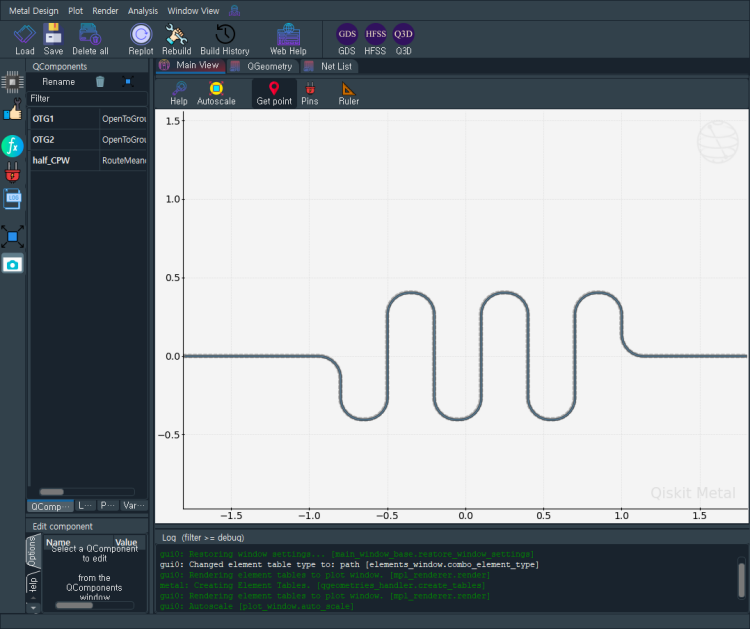

In [9]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

# everytime you need to redefine the component, you should delete the misdefined components
design.delete_all_components()

# open at the right end
OTG1 = OpenToGround(design, name='OTG1', options=dict(pos_x='1.8mm',  pos_y='0um', orientation='0'))

# short at the left end
OTG2 = OpenToGround(design, name='OTG2', options=dict(pos_x='-1.8mm',  pos_y='0um', orientation='180'))

# check all the options carefully
half_CPW_options = Dict(trace_width ='10um',    # CPW width
                        trace_gap ='6um',       # CPW gap
                        total_length='7.61 mm', # CPW length
                        hfss_wire_bonds = True, # wire-bonds along the CPW trace (what is wire bond? check: Z Chen et al., APL, 104, 052602 (2014) https://doi.org/10.1063/1.4863745)
                        fillet='140 um',        # radius of the fillet
                        meander = dict(spacing = '300um',   # spacing between the meander lines
                                       asymmetry = '0um'),  # asymmetric offset
                        lead = dict(start_straight='500um', # straight start length
                                    end_straight='500um'),  # straight end length
                        pin_inputs=Dict(start_pin=Dict(component='OTG1', pin='open'), # start pin, check the component "NAME" and "PIN" carefully
                                        end_pin=Dict(component='OTG2', pin='open')) # start pin, check the component "NAME" and "PIN" carefully
                        )

# design your own CPW resonator
R1 = RouteMeander(design, name='half_CPW', options=half_CPW_options)

# rebuild the GUI (if not, you can't see the components)
gui.rebuild()

# auto-rescale the GUI
gui.autoscale()

# take a screenshot of the GUI
gui.screenshot()

## set eigenmode simulation setup

In [10]:
from qiskit_metal.analyses.quantization import EPRanalysis

# project name
proj_name = "lab01_halfCPW"

# define the EPR analysis class
eig_s = EPRanalysis(design, "hfss")

# define the renderer program for the eigenmode simulation
hfss = eig_s.sim.renderer

try:
    hfss.start()
except:
    hfss.activate_design(proj_name)

# define the setup
em_s = eig_s.sim.setup
em_s.name = "setup_custom"

# define the setup
em_s = eig_s.sim.setup
em_s.name = "setup_custom"

# minimum searching frequency
em_s.min_freq_ghz = 5

# target eigenmode number
em_s.n_modes = 1

# maximum pass number
em_s.max_passes = 15

# criteria for eigenmode simulation convergence: maximum delta F_eigen between passes < value
em_s.max_delta_f = 0.1

# simulation minimum converged passes 
em_s.min_converged = 2

# simulation order 0: point, 1: line, 2: face
em_s.basis_order = 1

# Design variables can also be added in for direct simulation sweeps. Here, we don't have to care this since we don't have a qubit
em_s.vars = Dict({'Lj': '0 nH', 'Cj': '0 fF'})

INFO 01:47PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:47PM [load_ansys_project]: 	Opened Ansys App
INFO 01:47PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 01:47PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/USER/Documents/Ansoft/
	Project:   Project3
INFO 01:47PM [connect_design]: 	Opened active design
	Design:    lab01_quarterCPW_hfss [Solution type: Eigenmode]
INFO 01:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:47PM [connect]: 	Connected to project "Project3" and design "lab01_quarterCPW_hfss" 😀 



## render your $\lambda/2$ CPW resonator to the ANSYS HFSS

In [11]:
eig_s.sim._render(name=proj_name,                   # design name
                  selection = [],                         # if None --> all
                  solution_type='eigenmode',              # NOTE: case sensitive
                  vars_to_initialize=em_s.vars,           # set variables
                  open_pins=[('OTG1', 'open'), ('OTG2', 'open')], # set open pins
                  port_list=[],                           # set ports, for eigenmode simulations --> R = 50 Ohm boundary conditions 
                  box_plus_buffer = False)                # if False --> set the overall layout as you defined above. If True --> set marginal chip sizes as you set here.

INFO 01:47PM [connect_design]: 	Opened active design
	Design:    lab01_halfCPW_hfss [Solution type: Eigenmode]
WARNING 01:47PM [connect_setup]: 	No design setup detected.
WARNING 01:47PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


'lab01_halfCPW_hfss'

## set mesh configurations

In [13]:
# mesh setting name, components, maximum mesh length
hfss.modeler.mesh_length('cpw_mesh_setting', ['trace_half_CPW'], MaxLength='0.02 mm')

## start the eigenmode simulation

In [14]:
eig_s.sim._analyze()

INFO 01:47PM [get_setup]: 	Opened setup `setup_custom`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:47PM [analyze]: Analyzing setup setup_custom
01:56PM 29s INFO [get_f_convergence]: Saved convergences to c:\Users\USER\Documents\GitHub\sqc_lecture_notes\tutorials\hfss_eig_f_convergence.csv


In [15]:
eig_s.sim.plot_convergences()

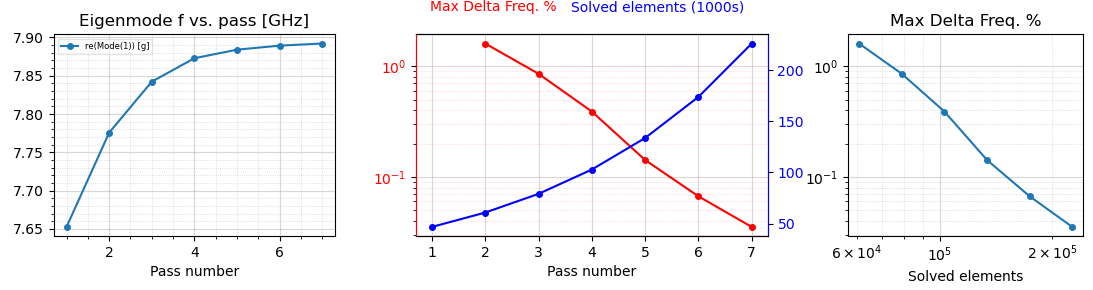

## check the result

In [16]:
eig_s.get_frequencies()

Design "lab01_halfCPW_hfss" info:
	# eigenmodes    1
	# variations    1
Design "lab01_halfCPW_hfss" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.892119,1.091025e+09


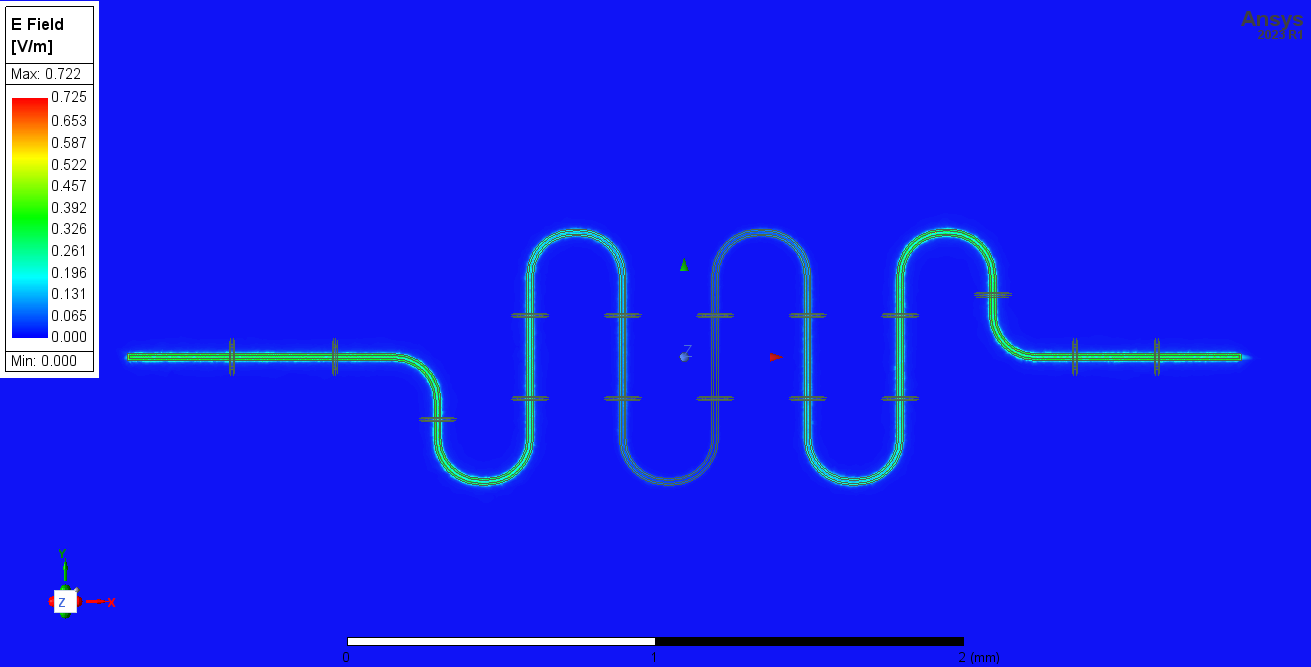

WindowsPath('c:/Users/USER/Documents/GitHub/sqc_lecture_notes/tutorials/ansys.png')

In [ ]:
eig_s.sim.plot_fields('main')
eig_s.sim.save_screenshot()

## Checklist
* Did the simulation converge well?
* Did the electromagnetic field show the resonant mode as you expected?
* Did the simulation exhibit the expected resonant frequency?
* If not, what design options you should modify?

# LAB HOMEWORK

### NOTE: You should achieve the target parameters within 2\%. The electric field distribution as well as the convergence plot vs. adaptive pass should be attached to the report.

1. Design a $\lambda/2$ CPW resonator to have $\omega_r/2\pi=6.0$ GHz within `3 mm x 3 mm chip`. NOTE that you have to define the mesh configuration for the ground plane of the chip (maximum mesh length constraint: 0.3 mm).
2. Design a $\lambda/2$ CPW resonator to have $\omega_r/2\pi=5.0$ GHz within `3 mm x 3 mm chip`. NOTE that you have to define the mesh configuration for the ground plane of the chip (maximum mesh length constraint: 0.3 mm).
3. Modify the substrate material into `sapphire` with a dielectric constant of `10`. Then, design a $\lambda/2$ CPW resonator to have $\omega_r/2\pi=7.0$ GHz within `4 mm x 2 mm chip`. NOTE that you have to define the mesh configuration for the ground plane of the chip (maximum mesh length constraint: 0.3 mm).